## 自己复现单层神经网络模型的时候重要的几个参数是：
### _n_input, n_output, n_epoch, batch_size_
### _net_
### _loss_
### _optimizer_

In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt
import sys
#sys.path.append("..")
import d2lzh_pytorch as d2l
import mypytorch

In [2]:
x = torch.rand(2, 3, 2)
x

tensor([[[0.7140, 0.3504],
         [0.3935, 0.7389],
         [0.7072, 0.9390]],

        [[0.4803, 0.9079],
         [0.5383, 0.2643],
         [0.1205, 0.8514]]])

In [3]:
x.argmax(dim=0)

tensor([[0, 1],
        [1, 0],
        [0, 0]])

In [4]:
x.argmax(dim=1)

tensor([[0, 2],
        [1, 0]])

In [5]:
x.argmax(dim=2)

tensor([[0, 1, 1],
        [1, 0, 1]])

In [6]:
x = torch.tensor([[1. ,2., 3.], [1., 2., 3.]], requires_grad=True)
y = torch.pow(x, 2)
y.backward(torch.ones_like(y))
x, y, x.grad

(tensor([[1., 2., 3.],
         [1., 2., 3.]], requires_grad=True),
 tensor([[1., 4., 9.],
         [1., 4., 9.]], grad_fn=<PowBackward0>),
 tensor([[2., 4., 6.],
         [2., 4., 6.]]))

In [7]:
def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

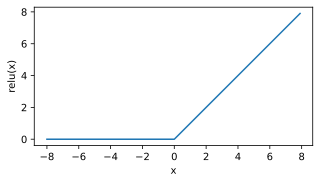

In [8]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

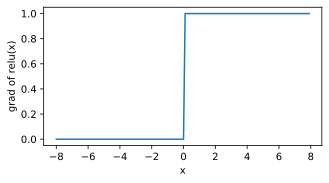

In [9]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

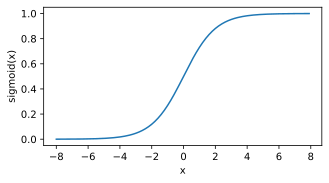

In [10]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

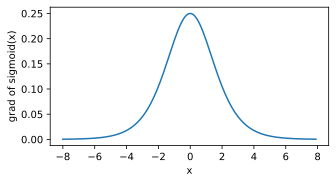

In [11]:
x.grad.zero_()#清除梯度
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

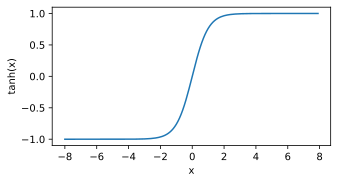

In [12]:
y = x.tanh()
xyplot(x, y, 'tanh')

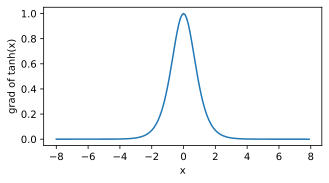

In [13]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

## 多项式拟合实验

In [14]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) # 张量按行拼接，其实就是3个输入
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b) # 标签y=1.2*x-3.4*x^2+5.6*x^3+5
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # 增加干扰量
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.1438],
         [ 0.8316]]),
 tensor([[-0.1438,  0.0207, -0.0030],
         [ 0.8316,  0.6915,  0.5750]]),
 tensor([4.7445, 6.8405]))

In [15]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)


def fit_and_plot(train_features, test_features, train_labels, test_labels):
    num_epochs, loss = 100, torch.nn.MSELoss()
    net = torch.nn.Linear(train_features.shape[-1], 1)  # 其实相当于初始化一个随机的W（100*1）和b
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])  # 小批量
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)  # 优化器，这里是用梯度下降
    train_ls, test_ls = [], []  # 记录的损失
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))  # net算出来的是估计值，与y值计算做损失值
            optimizer.zero_grad()  # 梯度清零
            l.backward()  # 计算梯度
            optimizer.step()  # 优化器更新
        train_labels = train_labels.view(-1, 1)  # 训练的y
        test_labels = test_labels.view(-1, 1)  # 测试的y
        train_ls.append(loss(net(train_features), train_labels).item())  # 记录更新之后的net损失值
        test_ls.append(loss(net(test_features), test_labels).item())  # 记录更新之后的net损失值
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',  # 画图
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,  # 输出权重和偏置
          '\nbias:', net.bias.data)


##### 正常拟合

final epoch: train loss 8.00646303105168e-05 test loss 0.00012006830365862697
weight: tensor([[ 1.2039, -3.3990,  5.5997]]) 
bias: tensor([4.9975])


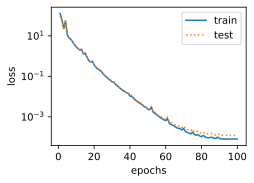

In [16]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

##### 欠拟合（非线性用线性模型训练）

final epoch: train loss 195.09373474121094 test loss 122.58439636230469
weight: tensor([[19.0380]]) 
bias: tensor([0.7350])


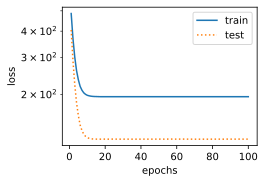

In [17]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

##### 过拟合（样本太小）

final epoch: train loss 0.44425955414772034 test loss 378.4521484375
weight: tensor([[1.4339, 1.3695, 1.1428]]) 
bias: tensor([3.9849])


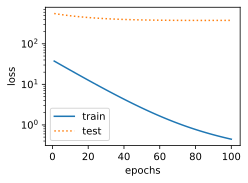

In [18]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

## 权重衰减
权重衰减等价于 L2范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段

## 高维线性回归实验

In [19]:
def l2_penalty(w):
    return (w**2).sum()/2

def init_params(num_inputs):
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def fit_and_plot2(train_features, test_features, train_labels, test_labels, lambd):
    batch_size, num_epochs, lr = 1, 100, 0.003
    net, loss = d2l.linreg, d2l.squared_loss

    w, b = init_params(train_features.shape[-1])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_labels = train_labels.view(-1, 1)  # 训练的y
        test_labels = test_labels.view(-1, 1)  # 测试的y
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())  # 记录更新之后的net损失值
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())  # 记录更新之后的net损失值
    # print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',  # 画图
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight.norm:', w.norm().item())  # 输出权重L2范数
          # '\nbias:', b.item())

In [20]:
n_train, n_test, n_input = 20, 100, 200
true_w, true_b = torch.ones(n_input, 1) * 0.01, 0.05
features = torch.randn((n_train + n_test, n_input))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # 增加干扰量
train_features, test_features = features[:n_train], features[n_train:]
train_labels, test_labels = labels[:n_train], labels[n_train:]

#### 不使用权重衰减下的过拟合（因为这里刻意限制训练集大小）

weight.norm: 13.655186653137207


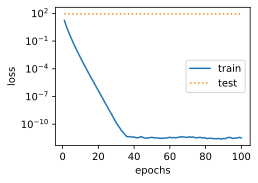

In [21]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 0)

#### 将lambd值逐渐调高，可见过拟合现象减弱，且权重的L2范数更加接近于0

weight.norm: 0.03346947953104973


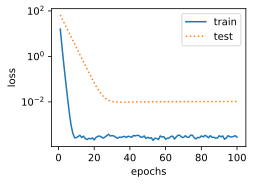

In [22]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 3)

weight.norm: 0.028466088697314262


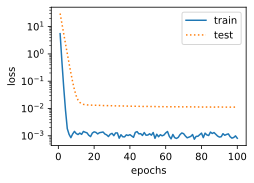

In [23]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 7)

### 用pytorch实现

In [24]:
def fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,wd):
    batch_size, num_epochs, lr = 1, 100, 0.003
    loss = torch.nn.MSELoss()
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = torch.nn.Linear(train_features.shape[-1], 1)
    torch.nn.init.normal_(net.weight, mean=0, std=1)
    torch.nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())


L2 norm of w: 13.317440032958984


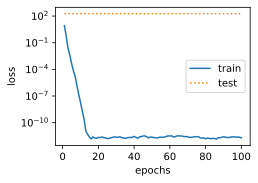

In [25]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,0)

L2 norm of w: 0.04260575398802757


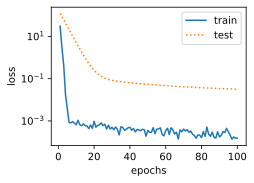

In [26]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,3)

L2 norm of w: 0.03765307366847992


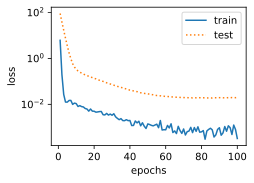

In [27]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,7)

## Module 类

In [28]:
# 自己写的带两个隐藏层（hidden1 hidden2）和一个激活函数（act）的模型
class MLP(nn.Module):
    def __init__(self, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.hidden1 = nn.Linear(784, 256) # 其实就是一个带可变参数的矩阵 有w和b
        self.act = nn.ReLU()
        self.hidden2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, X):
        return self.output(self.hidden2(self.act(self.hidden1(X))))

In [29]:
net = MLP()
x = torch.randn((10, 784))
net ,net(x)

(MLP(
   (hidden1): Linear(in_features=784, out_features=256, bias=True)
   (act): ReLU()
   (hidden2): Linear(in_features=256, out_features=128, bias=True)
   (output): Linear(in_features=128, out_features=10, bias=True)
 ),
 tensor([[ 0.0821,  0.2039, -0.2107,  0.2565, -0.0304, -0.1483, -0.2104, -0.1399,
           0.0970,  0.0362],
         [ 0.1435, -0.0628, -0.0291, -0.0288,  0.2091, -0.0212,  0.1164, -0.2148,
           0.0380,  0.0489],
         [-0.0725, -0.0204, -0.0692,  0.1839,  0.0266, -0.2500,  0.0660, -0.1424,
           0.0135,  0.1133],
         [-0.0637,  0.2412, -0.1150, -0.1084, -0.0485, -0.2745, -0.1514,  0.0309,
           0.1694,  0.0494],
         [-0.1289,  0.1131, -0.0580,  0.1161, -0.0834, -0.4336,  0.0584,  0.0897,
           0.0047,  0.1112],
         [ 0.0149,  0.2992, -0.0866,  0.2077, -0.0130, -0.2313,  0.1337, -0.0029,
          -0.0539, -0.0465],
         [-0.0444,  0.0901, -0.0019,  0.1431,  0.1336, -0.2998,  0.0903,  0.0181,
           0.0114, -0.1350

## 卷积

In [30]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
mypytorch.corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [31]:
from mypytorch import corr2d
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

#### 边缘滤波

In [32]:
X = torch.ones(6, 8)
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [33]:
K = torch.tensor([[-1, 1]])
Y = corr2d(X, K)
Y

tensor([[ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.]])

#### 用卷积层来求出边缘滤波

step 5 loss: 14.790
step 10 loss: 3.912
step 15 loss: 1.066
step 20 loss: 0.294
weight: tensor([[-0.8567,  0.8685]])
bias: tensor([-0.0066])


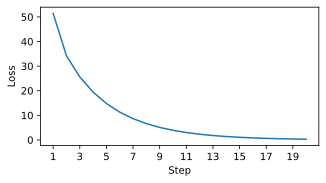

In [40]:
from mypytorch import loss_plot
conv2d = Conv2D(kernel_size=(1, 2))

step = 20
lr = 0.01
l_list = []
for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y - Y_hat)**2).sum()
    l_list.append(l.data)

    l.backward()

    conv2d.weight.data -= lr * conv2d.weight.grad  # 这边权重用data的原因是不希望这边的变化计入grad中
    conv2d.bias.data -= lr * conv2d.bias.grad

    conv2d.weight.grad.fill_(0)
    conv2d.bias.grad.fill_(0)

    if (i+1) % 5 == 0:
        print('step {} loss: {:.3f}'.format(i+1, l.item()))

print(f'weight: {conv2d.weight.data}\nbias: {conv2d.bias.data}')
loss_plot(list(range(1, 21)), l_list, x_limit=2)
